In [12]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [5]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes


In [6]:
# Save the input and target variables

data = load_diabetes()
data['data'].shape, data['target'].shape, data.keys()

((442, 10),
 (442,),
 dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename']))

In [7]:
dataset = data['data']

In [8]:
targets = (data['target'] - data['target'].mean(axis=0)) / data['target'].std()

In [17]:
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [9]:
# Normalise the target data (this will make clearer training curves)

max([max(i) for i in data['data']])

0.198787989657293

In [10]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data,test_data,train_label,test_label = train_test_split(dataset,targets,test_size=0.1)

train_data.shape

(397, 10)

#### Train a feedforward neural network model

In [21]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu',input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1)
])


In [22]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
model.compile(loss='mse',optimizer='sgd',metrics=['mae'])


In [32]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_label,validation_split=0.10,epochs=15)

Train on 357 samples, validate on 40 samples
Epoch 1/15
357/357 [==============================] - 0s 156us/sample - loss: 0.7832 - mae: 0.7589 - val_loss: 0.9480 - val_mae: 0.7984
Epoch 2/15
357/357 [==============================] - 0s 63us/sample - loss: 0.7765 - mae: 0.7555 - val_loss: 0.9369 - val_mae: 0.7911
Epoch 3/15
357/357 [==============================] - 0s 277us/sample - loss: 0.7687 - mae: 0.7494 - val_loss: 0.9433 - val_mae: 0.7870
Epoch 4/15
357/357 [==============================] - 0s 272us/sample - loss: 0.7604 - mae: 0.7432 - val_loss: 0.9422 - val_mae: 0.7832
Epoch 5/15
357/357 [==============================] - 0s 280us/sample - loss: 0.7544 - mae: 0.7384 - val_loss: 0.9073 - val_mae: 0.7736
Epoch 6/15
357/357 [==============================] - 0s 273us/sample - loss: 0.7442 - mae: 0.7375 - val_loss: 0.9052 - val_mae: 0.7694
Epoch 7/15
357/357 [==============================] - 0s 66us/sample - loss: 0.7401 - mae: 0.7346 - val_loss: 0.8997 - val_mae: 0.7646
Epoch

In [28]:
# Evaluate the model on the test set

loss,mae = model.evaluate(test_data,test_label)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [29]:
loss

0.7082961055967543

#### Plot the learning curves

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

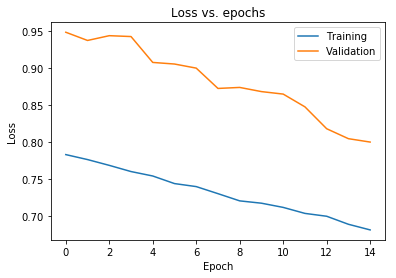

In [33]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [3]:
from tensorflow.keras.layers import Dropout,Dense
from tensorflow.keras import regularizers

In [4]:
def get_regularised_model(wd, rate):
    model = tf.keras.models.Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(wd)),
        tf.keras.layers.Dropout(0.3),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(wd)),
        Dropout(0.1),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(wd)),
        Dropout(0.1),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(wd)),
        Dropout(0.2),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(wd)),
        Dense(1)
    ])
    return model

In [49]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(0.01,0.2)
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

In [50]:
# Compile the model

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [51]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_label,validation_split=0.10,epochs=15)

Train on 357 samples, validate on 40 samples
Epoch 1/15
357/357 [==============================] - 2s 6ms/sample - loss: 6.7657 - mae: 0.8434 - val_loss: 6.2580 - val_mae: 0.9397
Epoch 2/15
357/357 [==============================] - 0s 829us/sample - loss: 5.4877 - mae: 0.8409 - val_loss: 5.1124 - val_mae: 0.9306
Epoch 3/15
357/357 [==============================] - 0s 843us/sample - loss: 4.4439 - mae: 0.8314 - val_loss: 4.1682 - val_mae: 0.9066
Epoch 4/15
357/357 [==============================] - 0s 843us/sample - loss: 3.5845 - mae: 0.8079 - val_loss: 3.3195 - val_mae: 0.8289
Epoch 5/15
357/357 [==============================] - 0s 833us/sample - loss: 2.8180 - mae: 0.7313 - val_loss: 2.4325 - val_mae: 0.6401
Epoch 6/15
357/357 [==============================] - 0s 847us/sample - loss: 2.2487 - mae: 0.6263 - val_loss: 1.9245 - val_mae: 0.5708
Epoch 7/15
357/357 [==============================] - 0s 835us/sample - loss: 1.9387 - mae: 0.6688 - val_loss: 1.6410 - val_mae: 0.5827
Epoch

In [52]:
# Evaluate the model on the test set

loss,mae = model.evaluate(test_data,test_label)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

#### Plot the learning curves

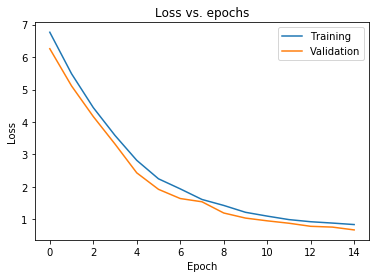

In [53]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCall(Callback):
    def on_predict_begin(self,logs=None):
        print(f'starting the training')
    def on_epoch_begin(self,epoch,logs=None):
        print(f'starting epoch {epoch}')
    def on_predict_batch_begin(self,batch,logs=None):
        print(f'starting the training batch {batch}')
    def on_predict_batch_end(self,batch,logs=None):
        print(f'ending the batch')

In [13]:
# Re-build the model
model = get_regularised_model(0.01,0.2)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [14]:
# Compile the model
model.compile(optimizer='adam',loss='mse',metrics=['mae'])


#### Train the model with the callback

In [18]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data,train_label,validation_split=0.10,epochs=15,callbacks=[TrainingCall()])

Train on 357 samples, validate on 40 samples
starting the training
starting epoch 0
Epoch 1/15
starting the training batch 0
ending the batch
 32/357 [=>............................] - ETA: 16s - loss: 7.1501 - mae: 0.7458starting the training batch 1
ending the batch
 64/357 [====>.........................] - ETA: 7s - loss: 7.2591 - mae: 0.8052 starting the training batch 2
ending the batch
starting the training batch 3
ending the batch
starting the training batch 4
ending the batch
160/357 [============>.................] - ETA: 2s - loss: 7.0336 - mae: 0.8043starting the training batch 5
ending the batch
starting the training batch 6
ending the batch
starting the training batch 7
ending the batch
starting the training batch 8
ending the batch
288/357 [=======================>......] - ETA: 0s - loss: 6.8771 - mae: 0.8481starting the training batch 9
ending the batch
starting the training batch 10
ending the batch
starting the training batch 11
ending the batch
357/357 [============

In [19]:
# Evaluate the model

loss,mae = model.evaluate(test_data,test_label)

45/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [21]:
# Make predictions with the model

model.predict(test_data,callbacks=[TrainingCall()])

starting the training
starting the training batch 0
ending the batch
starting the training batch 1
ending the batch


array([[-0.7635761 ],
       [-0.7279697 ],
       [-0.7325211 ],
       [-0.7363682 ],
       [ 0.18109734],
       [ 1.1393358 ],
       [-0.34127238],
       [-0.5900603 ],
       [ 0.92448276],
       [-0.7211402 ],
       [ 0.97526246],
       [-0.88495994],
       [-0.5806158 ],
       [-0.50103146],
       [-0.839859  ],
       [-0.8596109 ],
       [-0.8911378 ],
       [-0.62242514],
       [-0.7980188 ],
       [ 0.862235  ],
       [-0.6127866 ],
       [ 0.89228886],
       [ 0.17719048],
       [ 0.79727674],
       [ 0.30266494],
       [ 0.34729782],
       [-0.70950985],
       [-0.6180489 ],
       [ 0.09434801],
       [-0.06295452],
       [ 0.08290308],
       [ 0.77523226],
       [-0.25863338],
       [-0.6532944 ],
       [-0.6892901 ],
       [-0.70292205],
       [ 0.92422324],
       [-0.63041735],
       [ 0.4380939 ],
       [-0.8855282 ],
       [-0.22700898],
       [-0.6842013 ],
       [-0.8016133 ],
       [-0.171039  ],
       [ 0.01886093]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stoppage = EarlyStopping(monitor='val_mae',patience=3,mode='auto',min_delta=0.01)

In [30]:
# Re-train the unregularised model

model = get_regularised_model(0.01,0.2)
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
unreg_history = model.fit(train_data,train_label,validation_split=0.10,epochs=15,callbacks=[early_stoppage])

Train on 357 samples, validate on 40 samples
Epoch 1/15
357/357 [==============================] - 2s 6ms/sample - loss: 6.8104 - mae: 0.8521 - val_loss: 5.9547 - val_mae: 0.7938
Epoch 2/15
357/357 [==============================] - 0s 796us/sample - loss: 5.5254 - mae: 0.8472 - val_loss: 4.8045 - val_mae: 0.7814
Epoch 3/15
357/357 [==============================] - 0s 846us/sample - loss: 4.4688 - mae: 0.8303 - val_loss: 3.8570 - val_mae: 0.7539
Epoch 4/15
357/357 [==============================] - 0s 839us/sample - loss: 3.5660 - mae: 0.7780 - val_loss: 3.0262 - val_mae: 0.6714
Epoch 5/15
357/357 [==============================] - 0s 1ms/sample - loss: 2.7983 - mae: 0.6790 - val_loss: 2.4415 - val_mae: 0.6045
Epoch 6/15
357/357 [==============================] - 0s 855us/sample - loss: 2.2507 - mae: 0.5897 - val_loss: 2.0110 - val_mae: 0.5989
Epoch 7/15
357/357 [==============================] - 0s 849us/sample - loss: 1.8795 - mae: 0.5970 - val_loss: 1.7147 - val_mae: 0.5911
Epoch 8

In [28]:
# Evaluate the model on the test set

model.evaluate(test_data,test_label,verbose=2)

45/1 - 0s - loss: 1.2444 - mae: 0.6349


[1.3843852493498061, 0.63494426]

In [ ]:
# Re-train the regularised model



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

NameError: name 'reg_history' is not defined

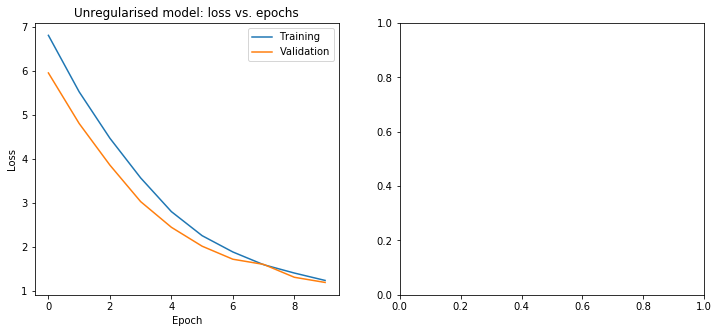

In [31]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()